<a href="https://colab.research.google.com/github/sachchd/Coursera_Capstone/blob/main/Indian_Restaurants_in_Toronto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - Analyzing Toronto and Clustering Neighbourhoods (Week 2)


### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* Introduction
* Business Problem
* Data
* Methodology
* Analysis
* Results and Discussion
* Conclusion

#Introduction
Toronto is considered as the most multicultural city of the world with nearly half of its population born outside of Canada. As a result, residents of this place get to enjoy a variety of cuisines just by walking through its neighbourhoods. Neighborhoods like little Italy, little Poland, little India offer a totally different cultural experience and a chance to try out new food without ever leaving the country.

#Business Problem
We can safely assume that in an Indian neighbourhood there would be plenty of Indian restaurants. Consequently, there would be a lot of competition between the restaurants and a new restaurant would have to compete with the well-established places which is difficult to accomplish.
Our problem is that we are looking to build a new Indian restaurant and looking for a suitable place for it.Therefore, we are analyzing the neighbourhoods of Toronto and look the places which are the best places to open an Indian restaurant.

#Data

We are using the Foursquare API which gives us the information about the **venues** in the neighbourhoods i.e. we get **venue's latitude,longitude,name and category** which is useful while clustering the neighbourhoods and the venues

We are using [Wikipedia's Postal code data of Toronto](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) to get all the boroughs and postal code of each neighbourhood which we helpful for plotting when combined with the geographical coordinates of Toronto.

To get the coordinates of each neighbourhood in Toronto, we have used **Geopy** library. As we have prepared the data from both Wikipedia and geopy in last week, we going to import that data instead of going through all the steps.



In [1]:
import pandas as pd
trnt = pd.read_csv('/content/Toronto Zipcodes with Coordinates.csv')

In [2]:
trnt.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [3]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(trnt['Borough'].unique()),
        trnt.shape[0]
    )
)

The dataframe has 15 boroughs and 103 neighborhoods.


Getting the number of neighbourhoods in each Borough

In [4]:
nbhd_count = trnt.groupby('Borough').count()
nbhd_count.drop(columns=['Postal Code','Latitude','Longitude'],inplace=True)
nbhd_count.sort_values(by='Neighborhood',ascending=False,inplace=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

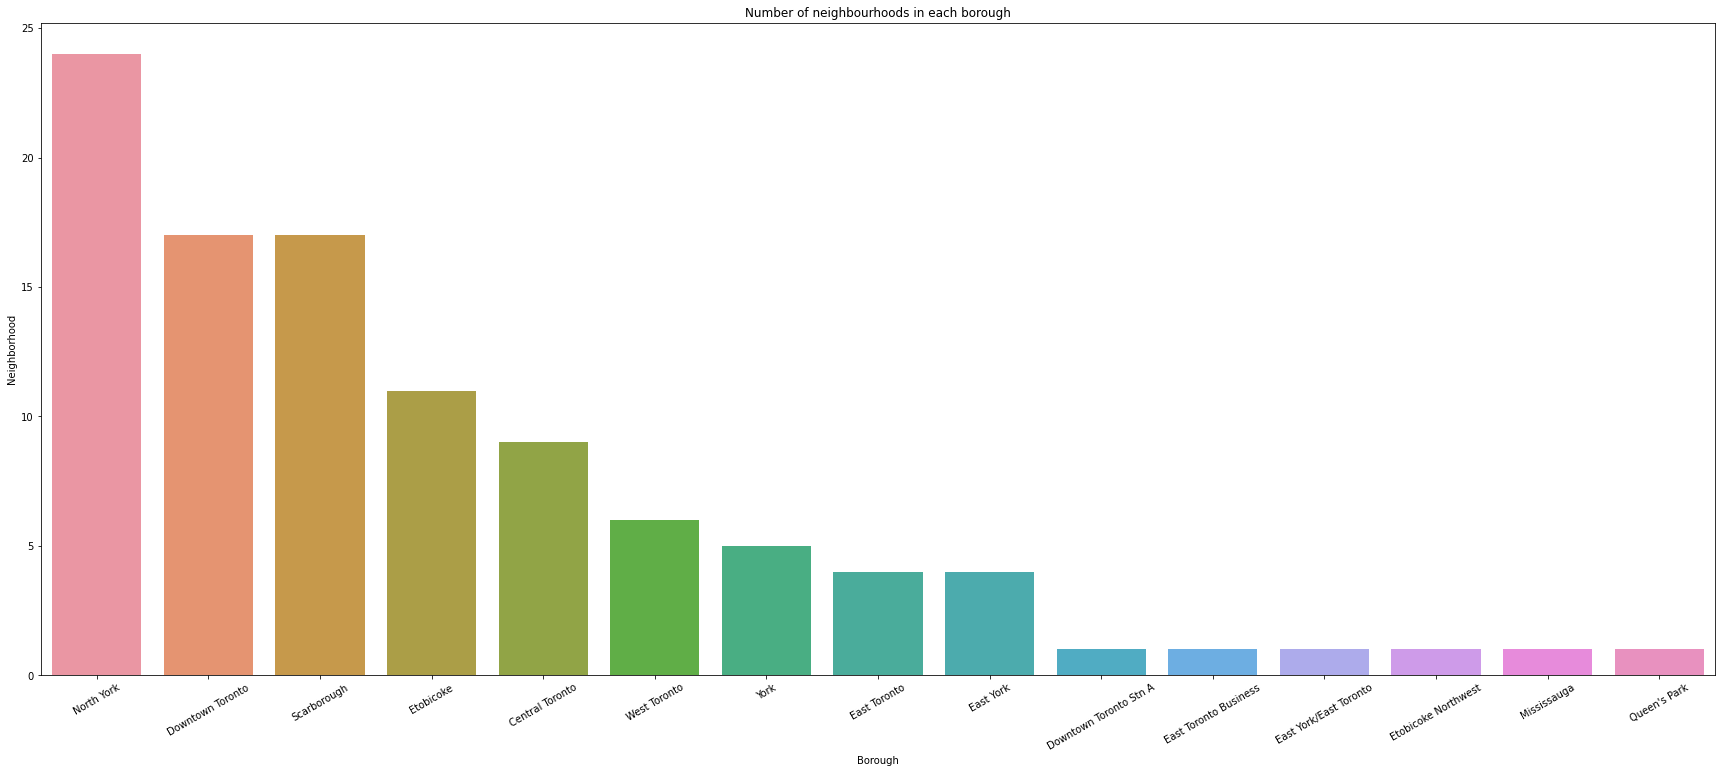

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(30,12))
ax = sns.barplot(x = nbhd_count.index ,y = nbhd_count.Neighborhood,data = nbhd_count)
plt.title('Number of neighbourhoods in each borough')
#ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.xticks(rotation=30)

We can see that North York, Downtown Toronto and Scarborough have a lot of neighbourhoods as compared to other boroughs.

In this project we will direct our efforts on detecting areas of Berlin that have low restaurant density, particularly those with low number of Italian restaurants. We will limit our analysis to area ~6km around city center.

In first step we have collected the required **data: location and type (category) of every restaurant within 6km from Berlin center** (Alexanderplatz). We have also **identified Italian restaurants** (according to Foursquare categorization).

Second step in our analysis will be calculation and exploration of '**restaurant density**' across different areas of Berlin - we will use **heatmaps** to identify a few promising areas close to center with low number of restaurants in general (*and* no Italian restaurants in vicinity) and focus our attention on those areas.

In third and final step we will focus on most promising areas and within those create **clusters of locations that meet some basic requirements** established in discussion with stakeholders: we will take into consideration locations with **no more than two restaurants in radius of 250 meters**, and we want locations **without Italian restaurants in radius of 400 meters**. We will present map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify general zones / neighborhoods / addresses which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders.

# Methodology

In this project our goal is to find suitable neighbourhoods to open up an Indian restaurant. We are going to find out areas which have low density of Indian restaurants. 

Also, another way of predicting whether our restaurant would be successful or not is by observing the number of venues in that area. If there are a lot of venues in that neighborhood, it is safe to assume that people also go there. We have capped the number of venues to 100 per neighborhood.

In the first step we have collected the required data: location and category of every venue and plotted them on the map and identified all the Indian restaurants and also plotted them.

In the second step we explore the neighborhoods and look at the density of the venues and plot them using heatmaps.

In the third step we find the neighbourhoods which have similar venues and cluster them using KMeans clustering. This would help us identify which neighbourhoods are similar and also which would be better for our restaurant.


# Analysis

Getting the Coordinates of Toronto to draw the map

In [6]:
from geopy.geocoders import Nominatim
address = 'Toronto,ON'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [7]:
import folium

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude,longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(trnt['Latitude'], trnt['Longitude'], trnt['Borough'], trnt['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Defining Foursquare credentials

In [8]:
CLIENT_ID = 'ZLRC0UEU0K0UXUCV3PPD35EUBN1PIMB5MNCB4BGNUDDSD3ZO' # your Foursquare ID
CLIENT_SECRET = 'KH0T0GKHLKDBAPDHY0F3YUCG45L4JIGX2UOYLXDAFYIFZIM4' # your Foursquare Secret
VERSION = '20190425' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZLRC0UEU0K0UXUCV3PPD35EUBN1PIMB5MNCB4BGNUDDSD3ZO
CLIENT_SECRET:KH0T0GKHLKDBAPDHY0F3YUCG45L4JIGX2UOYLXDAFYIFZIM4


## Defining a function to explore all the neighbourhoods in Downtown Toronto

The Foursquare API doesn't need the names of the neighbourhoods, just the latitude and longitude of it.

The function created does the following

*   Prints the name of the neighbourhood from our dataset
*   Gets the data of the 100 venues within 500 metres using Foursquare API
*   Creates a dataframe containing the required columns 






In [9]:
import requests
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
trnt_venues = getNearbyVenues(trnt['Neighborhood'],trnt['Latitude'],trnt['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

Checking the resulting dataframe

In [11]:
trnt_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
...,...,...,...,...,...,...,...
2123,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Subway,43.631659,-79.519001,Sandwich Place
2124,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Jim & Maria's No Frills,43.631152,-79.518617,Grocery Store
2125,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,McDonald's,43.630007,-79.518041,Fast Food Restaurant
2126,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Koala Tan Tanning Salon & Sunless Spa,43.631370,-79.519006,Tanning Salon


Checking how many values were returned for each neighbourhood.

In [12]:
number_of_venues = trnt_venues.groupby('Neighborhood').count()

In [13]:
number_of_venues.sort_values(by = 'Venue',ascending = False).head(20)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"First Canadian Place, Underground city",100,100,100,100,100,100
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
"Harbourfront East, Union Station, Toronto Islands",100,100,100,100,100,100
"Garden District, Ryerson",100,100,100,100,100,100
"Toronto Dominion Centre, Design Exchange",100,100,100,100,100,100
Enclave of M5E,100,100,100,100,100,100
"Richmond, Adelaide, King",92,92,92,92,92,92
St. James Town,82,82,82,82,82,82
Church and Wellesley,80,80,80,80,80,80


In [14]:
print('There are {} uniques categories.'.format(len(trnt_venues['Venue Category'].unique())))

There are 272 uniques categories.


Finding the top 20 venue cateogries in Toronto

In [15]:
venues_count = trnt_venues.groupby('Venue Category').count()
venues_count.sort_values(by = 'Venue',ascending = False).head(20)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Coffee Shop,190,190,190,190,190,190
Café,94,94,94,94,94,94
Restaurant,65,65,65,65,65,65
Park,54,54,54,54,54,54
Pizza Place,48,48,48,48,48,48
Italian Restaurant,46,46,46,46,46,46
Hotel,43,43,43,43,43,43
Bakery,41,41,41,41,41,41
Japanese Restaurant,41,41,41,41,41,41


We can see that Indian Restaurants are not in the top 20 in Toronto. In the next step we find all of the Indian restaurants

In [16]:
ind_rst = trnt_venues[trnt_venues['Venue Category'].str.contains('Indian')].reset_index(drop=True)

In [17]:
ind_rst

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,43.644771,-79.373306,Bindia Indian Bistro,43.648559,-79.371816,Indian Restaurant
1,Central Bay Street,43.657952,-79.387383,Colaba Junction,43.660940,-79.385635,Indian Restaurant
2,Thorncliffe Park,43.705369,-79.349372,Iqbal Kebab & Sweet Centre,43.705923,-79.351521,Indian Restaurant
3,Thorncliffe Park,43.705369,-79.349372,Hakka Garden,43.704578,-79.349770,Indian Restaurant
4,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,Indian Roti House,43.639060,-79.385422,Indian Restaurant
5,"The Danforth West, Riverdale",43.679557,-79.352188,Sher-E-Punjab,43.677308,-79.353066,Indian Restaurant
6,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,The Copper Chimney,43.736195,-79.420271,Indian Restaurant
7,"Dorset Park, Wexford Heights, Scarborough Town...",43.757410,-79.273304,Kairali,43.754915,-79.276945,Indian Restaurant
8,"Dorset Park, Wexford Heights, Scarborough Town...",43.757410,-79.273304,Karaikudi Chettinad South Indian Restaurant,43.756042,-79.276276,Indian Restaurant
9,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,Roti Cuisine of India,43.674618,-79.408249,Indian Restaurant


Plotting the Indian Restaurants on the map

In [18]:
import folium
ind_map = folium.Map(location=[latitude,longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood,name in zip(ind_rst['Neighborhood Latitude'], ind_rst['Neighborhood Longitude'], ind_rst['Neighborhood'],ind_rst['Venue']):
    label = '{}, {}'.format(name,neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(ind_map)    
ind_map

As we can see from the above map, Most of the Indian Restaurants are pretty spaced out except for Downtown Toronto where 3 restaurants are close.

So, there are very few restaurants to compete with when we open our restaurant. Therefore, we also need to consider another factor which the footfall of the place. Therefore we are going to analyze which neighbourhood has the most number of people going in and out of places.

In [19]:
heat_data = trnt_venues[['Venue Latitude','Venue Longitude']]

# creating a list to show the neighbourhoods with most number of venues
heat_data = [[row['Venue Latitude'],row['Venue Longitude']] for index, row in heat_data.iterrows()]

In [20]:
from folium.plugins import HeatMap

venues_map = folium.Map(location=[latitude,longitude], zoom_start=11)

HeatMap(heat_data).add_to(venues_map)
venues_map

From the above heatmap we can see that most of the venues located in Toronto are in Downtown Toronto and North York.

Since, there are a lot of places in **Downtown Toronto and North York**, it is *safe to assume that people visit these places* frequently and thus, are favourable places to open an Indian restaurant.

In [21]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Let's find out how many unique categories can be curated from all the returned venues


## Analyze each neighbourhood

In [22]:
# one hot encoding
trnt_onehot = pd.get_dummies(trnt_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
trnt_onehot['Neighborhood'] = trnt_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [trnt_onehot.columns[-1]] + list(trnt_onehot.columns[:-1])
trnt_onehot = trnt_onehot[fixed_columns]

trnt_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,...,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
trnt_onehot.shape

(2128, 272)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [24]:
trnt_grouped = trnt_onehot.groupby('Neighborhood').mean().reset_index()
trnt_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,...,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.0,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037037,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.037037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037037,0.0,0.0,0.0,0.037037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Willowdale West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,"Willowdale, Newtonbrook",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0

In [25]:
trnt_grouped.shape

(100, 272)

## Find the top 5 venues in each neighbourhood

In [26]:
num_top_venues = 5

for hood in trnt_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = trnt_grouped[trnt_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0                     Lounge  0.25
1  Latin American Restaurant  0.25
2             Breakfast Spot  0.25
3             Clothing Store  0.25
4                Yoga Studio  0.00


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.25
1             Pub  0.12
2        Pharmacy  0.12
3  Sandwich Place  0.12
4             Gym  0.12


----Bathurst Manor, Wilson Heights, Downsview North----
                venue  freq
0         Coffee Shop  0.09
1                Bank  0.09
2         Bridal Shop  0.05
3         Supermarket  0.05
4  Frozen Yogurt Shop  0.05


----Bayview Village----
                 venue  freq
0  Japanese Restaurant  0.25
1                 Café  0.25
2                 Bank  0.25
3   Chinese Restaurant  0.25
4  Moroccan Restaurant  0.00


----Bedford Park, Lawrence Manor East----
                     venue  freq
0           Sandwich Place  0.07
1       Italian Restaurant  0.07
2               Restaurant

#### Let's put that into a _pandas_ dataframe


First, let's write a function to sort the venues in descending order.


In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.


In [28]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

import numpy as np

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = trnt_grouped['Neighborhood']

for ind in np.arange(trnt_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(trnt_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Clothing Store,Breakfast Spot,Ethiopian Restaurant,Escape Room,Electronics Store,Event Space,Eastern European Restaurant,Dim Sum Restaurant
1,"Alderwood, Long Branch",Pizza Place,Pharmacy,Gym,Coffee Shop,Athletics & Sports,Sandwich Place,Pub,Distribution Center,Dim Sum Restaurant,Diner
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Intersection,Supermarket,Deli / Bodega,Sushi Restaurant,Ice Cream Shop,Shopping Mall,Mobile Phone Shop,Restaurant
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Dim Sum Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Restaurant,Coffee Shop,Italian Restaurant,Pizza Place,Boutique,Liquor Store,Juice Bar,Fast Food Restaurant,Japanese Restaurant


## Cluster Neighbourhoods

In [30]:
# set number of clusters
from sklearn.cluster import KMeans

kclusters = 5
trnt_grouped_clustering = trnt_grouped.drop('Neighborhood', 1)

# run k-means clustering

kmeans = KMeans(n_clusters=5, random_state=1011).fit(trnt_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [31]:
# add clustering labels

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

trnt_merged = trnt

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
trnt_merged = trnt_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

trnt_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,1.0,Food & Drink Shop,Fast Food Restaurant,Park,Women's Store,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Hockey Arena,Intersection,Coffee Shop,Portuguese Restaurant,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Park,Bakery,Breakfast Spot,Restaurant,Café,Pub,Theater,Yoga Studio,Spa
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,Accessories Store,Furniture / Home Store,Clothing Store,Shoe Store,Boutique,Coffee Shop,Miscellaneous Shop,Vietnamese Restaurant,Eastern European Restaurant,Electronics Store
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,0.0,Coffee Shop,Sushi Restaurant,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Salad Place,Burrito Place,Café,Portuguese Restaurant


In [32]:
trnt_merged.dropna(inplace=True)

In [33]:
trnt_merged['Cluster Labels']=trnt_merged['Cluster Labels'].astype(int)

In [34]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(trnt_merged['Latitude'], trnt_merged['Longitude'], trnt_merged['Neighborhood'], trnt_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examining Clusters

#### Cluster 1


In [35]:
trnt_merged.loc[trnt_merged['Cluster Labels'] == 0, trnt_merged.columns[[1] + list(range(5, trnt_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,0,Hockey Arena,Intersection,Coffee Shop,Portuguese Restaurant,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
2,Downtown Toronto,0,Coffee Shop,Park,Bakery,Breakfast Spot,Restaurant,Café,Pub,Theater,Yoga Studio,Spa
3,North York,0,Accessories Store,Furniture / Home Store,Clothing Store,Shoe Store,Boutique,Coffee Shop,Miscellaneous Shop,Vietnamese Restaurant,Eastern European Restaurant,Electronics Store
4,Queen's Park,0,Coffee Shop,Sushi Restaurant,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Salad Place,Burrito Place,Café,Portuguese Restaurant
6,Scarborough,0,Fast Food Restaurant,Dessert Shop,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
...,...,...,...,...,...,...,...,...,...,...,...,...
98,Etobicoke,0,River,Pool,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
99,Downtown Toronto,0,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Restaurant,Gay Bar,Yoga Studio,Hotel,Fast Food Restaurant,Pub,Smoke Shop
100,East Toronto Business,0,Yoga Studio,Garden Center,Light Rail Station,Brewery,Spa,Farmers Market,Fast Food Restaurant,Burrito Place,Restaurant,Recording Studio
101,Etobicoke,0,Construction & Landscaping,Pool,Baseball Field,Women's Store,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop


#### Cluster 2


In [36]:
trnt_merged.loc[trnt_merged['Cluster Labels'] == 1, trnt_merged.columns[[1] + list(range(5, trnt_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,1,Food & Drink Shop,Fast Food Restaurant,Park,Women's Store,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
21,York,1,Park,Women's Store,Pool,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
35,East York/East Toronto,1,Park,Convenience Store,Women's Store,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
40,North York,1,Park,Airport,Women's Store,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
52,North York,1,Park,Women's Store,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
61,Central Toronto,1,Park,Bus Line,Swim School,Women's Store,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
64,York,1,Park,Convenience Store,Jewelry Store,Women's Store,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
66,North York,1,Park,Convenience Store,Women's Store,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
77,Etobicoke,1,Mobile Phone Shop,Park,Sandwich Place,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store
83,Central Toronto,1,Park,Tennis Court,Trail,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant


#### Cluster 3


In [37]:
trnt_merged.loc[trnt_merged['Cluster Labels'] == 2, trnt_merged.columns[[1] + list(range(5, trnt_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,North York,2,Baseball Field,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Women's Store,Farmers Market


#### Cluster 4


In [38]:
trnt_merged.loc[trnt_merged['Cluster Labels'] == 3, trnt_merged.columns[[1] + list(range(5, trnt_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Scarborough,3,Playground,Women's Store,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant


#### Cluster 5


In [39]:
trnt_merged.loc[trnt_merged['Cluster Labels'] == 4, trnt_merged.columns[[1] + list(range(5, trnt_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Scarborough,4,Coffee Shop,Korean BBQ Restaurant,Women's Store,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant


# Results and Discussion

IIn our analysis we found that there are not a lot of Indian Restaurants in Toronto. So, we need not worry about the competing with other Indian restaurants. 

Therefore, we needed to find places which people frequent the most. I was planning to use the trending places in each neighbourhood instead of number of venues in a neighbourhood. I couldn't use the trending method because the Foursquare API was down at that moment.

So, by using a Heatmap we found out that areas around Downtown Toronto and North York have the greatest number of venues compared to other neighbourhoods. So, these are the areas where we can potentially open an Indian restaurant.
In the next step we clustered all the neighbourhoods based on the type of venue it had and found that cluster 0 i.e. the red cluster is the best cluster for us to consider as it has the most number of coffee shops, restaurants and delis/bodega. Therefore, are the high chances that if we open any type of restaurant in these areas, it would have a considerable amount of people coming in.


# Conclusion

We did our analysis on Toronto's neighborhood to come up with the best place to open an Indian Restaurant. After plotting the Heatmap and clustering the neighborhoods for similarity in venues, we found out that Downtown Toronto and the areas surrounding it are the best places to build a Indian restaurant.